### Libraries 

In [17]:
from scipy.io import loadmat
import pennylane as qml
import matplotlib.pyplot as plt
import itertools
import os
import torch

### Network data 

In [9]:
data_path = 'Folder stores Q_OPF/Q_OPF/data'
data = loadmat(os.path.join(data_path,'IEEE57VQEC1.mat'))

# Diagonals and rotation matrices: these tensors store matrices Lambda^c_m, U_c, U_c*S_c^dag
# for M_m based on the XBM decomposition
H_matrix = torch.tensor(data['H_matrix'], dtype=torch.complex64)
U_re = torch.tensor(data['U_re'], dtype=torch.complex64)
U_im = torch.tensor(data['U_im'], dtype=torch.complex64)

# Vector spec stores b_m in QCQP formula
spec = torch.tensor(data['S'].ravel())

# Hermitian matrices used to validate solutions later on
Mp = torch.tensor(data['Mp'])
Mq = torch.tensor(data['Mq'])

pd = torch.tensor(data['pd'].ravel())
qd = torch.tensor(data['qd'].ravel())
gen_val = torch.tensor(data['gen_mp'].ravel()).real

# Vectors store indices of loads and generators
LoadInd = torch.tensor(data['LoadInd'].ravel(), dtype=torch.long)  
GenInd = torch.tensor(data['GenInd'].ravel(), dtype=torch.long)   


# Network parameters
Nbus = int(data['Nbus'][0][0])
Nload = int(data['Nload'][0][0])
Ngen = int(data['Ngen'][0][0])
Nline = int(data['Nline'][0][0])
num_colors = int(data['num_colors'][0][0])

Mc = 2 * Nbus + 4 * Nload + 4 * Ngen + Nline # number of constraints
M = Mc + Ngen

# Load exact solution from Matpower
v_yalmip = torch.tensor(data['v_mp'].ravel())
lambda_val = torch.tensor(data['dual_mp'].ravel())

### PQC settings 

In [10]:
# Qubit calculations
n_primal = int(torch.ceil(torch.log2(torch.tensor(Nbus, dtype=torch.float32))).item())
n_dual = int(torch.ceil(torch.log2(torch.tensor(Mc))).item())

print('n_primal: ', n_primal)
print('n_dual: ', n_dual)

# Number of ansatz layers
Lp = 20
Ld = 35
gates_per_layer = 2 # each layer has two different types of rotation gates, e.g., RX and RY

# Quantum device setup
dev_primal = qml.device("default.qubit", wires=n_primal, shots=None)
dev_dual = qml.device("default.qubit", wires=n_dual, shots=None)

n_primal:  6
n_dual:  9


In [11]:
@qml.qnode(dev_primal, interface="torch") 
def sampling_primal(param1):
    for i in range(0, Lp, gates_per_layer):
        qml.BasicEntanglerLayers(
            weights=param1[i,:].reshape(1, n_primal),
            wires=range(n_primal),
            rotation=qml.RY
        )
        qml.BasicEntanglerLayers(
            weights=param1[i+1,:].reshape(1, n_primal),
            wires=range(n_primal),
            rotation=qml.RZ
        )
    return qml.state()

@qml.qnode(dev_dual, interface="torch")
def sampling_dual(param2):
    qml.BasicEntanglerLayers(
        weights=param2,
        wires=range(n_dual),
        rotation=qml.RY
    )
    return qml.state()

### Functions to compute the Lagrangian and its gradients 

In [12]:
def Leval(param1, param2, mu, nu):
    primal_state = sampling_primal(param1).to(dtype=torch.complex64)
    p_dual = torch.abs(sampling_dual(param2))**2
    feval = torch.tensor(0.0)
    Geval = torch.tensor(0.0)

    for c in range(num_colors):
        U_re_c = U_re[:, :, c]
        U_im_c = U_im[:, :, c]
        
        p_re_primal = torch.abs(U_re_c @ primal_state)**2
        p_im_primal = torch.abs(U_im_c @ primal_state)**2

        D_re_primal = torch.real(H_matrix[:, (c*M):(c*M+Ngen)])
        D_im_primal = torch.imag(H_matrix[:, (c*M):(c*M+Ngen)])

        feval += 2 * torch.sum(p_re_primal @ D_re_primal - p_im_primal @ D_im_primal)

        fmval_re_joint = p_re_primal @ torch.real(H_matrix[:, (c*M+Ngen):((c+1)*M)])
        fmval_im_joint = p_im_primal @ torch.imag(H_matrix[:, (c*M+Ngen):((c+1)*M)])

        Geval += 2 * (p_dual[:Mc] @ fmval_re_joint.to(torch.float64)
                      - p_dual[:Mc]  @ fmval_im_joint.to(torch.float64))

    seval = p_dual[:Mc] @ spec
    return mu * torch.real(feval) + mu * nu * torch.real(Geval) - nu * torch.real(seval)

# Note: gradients of the Lagragian wrt param1 and param2 are computed using Pennylane built-in functions
# Gradients of the Lagrangian wrt mu and nu are defined below.

def grad_mu(param1, param2, mu, nu):
    primal_state = sampling_primal(param1).to(dtype=torch.complex64)
    p_dual = torch.abs(sampling_dual(param2))**2
    feval = torch.tensor(0.0)
    Geval = torch.tensor(0.0)

    for c in range(num_colors):
        U_re_c = U_re[:, :, c]
        U_im_c = U_im[:, :, c]
        
        p_re_primal = torch.abs(U_re_c @ primal_state)**2
        p_im_primal = torch.abs(U_im_c @ primal_state)**2

        D_re_primal = torch.real(H_matrix[:, (c*M):(c*M+Ngen)])
        D_im_primal = torch.imag(H_matrix[:, (c*M):(c*M+Ngen)])

        feval += 2 * torch.sum(p_re_primal @ D_re_primal - p_im_primal @ D_im_primal)

        fmval_re_joint = p_re_primal @ torch.real(H_matrix[:, (c*M+Ngen):((c+1)*M)])
        fmval_im_joint = p_im_primal @ torch.imag(H_matrix[:, (c*M+Ngen):((c+1)*M)])

        Geval += 2 * (p_dual[:Mc]  @ fmval_re_joint.to(torch.float64) - p_dual[:Mc]  @ fmval_im_joint.to(torch.float64))

    return torch.real(feval) + nu * torch.real(Geval)

def grad_nu(param1, param2, mu, nu):
    primal_state = sampling_primal(param1).to(dtype=torch.complex64)
    p_dual = torch.abs(sampling_dual(param2))**2
    feval = torch.tensor(0.0)
    Geval = torch.tensor(0.0)

    for c in range(num_colors):
        U_re_c = U_re[:, :, c]
        U_im_c = U_im[:, :, c]
        
        p_re_primal = torch.abs(U_re_c @ primal_state)**2
        p_im_primal = torch.abs(U_im_c @ primal_state)**2

        fmval_re_joint = p_re_primal @ torch.real(H_matrix[:, (c*M+Ngen):((c+1)*M)])
        fmval_im_joint = p_im_primal @ torch.imag(H_matrix[:, (c*M+Ngen):((c+1)*M)])

        Geval += 2 * (p_dual[:Mc]  @ fmval_re_joint.to(torch.float64) - p_dual[:Mc]  @ fmval_im_joint.to(torch.float64))

    seval = p_dual[:Mc] @ spec
    return mu * torch.real(Geval) - torch.real(seval)


### Extragradient iterations

In [ ]:
# Initial parameters
torch.manual_seed(2)
shape1 = qml.BasicEntanglerLayers.shape(n_layers=Lp, n_wires=n_primal)
param1 = torch.randn(shape1, requires_grad=True)
param1_extra = param1

torch.manual_seed(15)
shape2 = qml.BasicEntanglerLayers.shape(n_layers=Ld, n_wires=n_dual)
param2 = torch.randn(shape2, requires_grad = True)
param2_extra = param2

mu, nu = Nbus, 2*Nload


# Initial step sizes
eta = {'param1': 0.015, 'param2': 0.01, 'mu': 10**-7, 'nu': 10**-5}

# Parameter for the intermediate step in EG
beta = 0.5

# Dictionaries to save data across iterations
history = {'cost': [], 'param1': [], 'param2': [], 'mu': [], 'nu': [], 'L': []}

prev_param1 = param1
prev_param2 = param2

max_iter = 70000

# Extragradient iteration
for it in range(1, max_iter):
    
    # Set the update rules for the intermediate iterates and main iterates
    param1_extra_groups = [
    {'params': [param1_extra], 'lr': eta['param1']*0.99985**it/beta}] # Positive LR for ascent
    extra_primal = torch.optim.Adam(param1_extra_groups, betas=(0.9, 0.99))
    
    param2_extra_groups = [
    {'params': [param2_extra], 'lr': -eta['param2']*0.99985**it/beta}]  # Negative LR for descent
    extra_dual = torch.optim.Adam(param2_extra_groups, betas=(0.9, 0.99))
    
    param1_groups = [
    {'params': [param1], 'lr': eta['param1']*0.99985**it}] # Positive LR for ascent
    opt_primal = torch.optim.Adam(param1_groups, betas=(0.9, 0.99))
    
    param2_groups = [
    {'params': [param2], 'lr': -eta['param2']*0.99985**it}]  # Negative LR for descent
    opt_dual = torch.optim.Adam(param2_groups, betas=(0.9, 0.99))
    
    # Reset gradients
    extra_primal.zero_grad()  
    extra_dual.zero_grad()
    opt_primal.zero_grad()  
    opt_dual.zero_grad()
    
    # Compute primal-dual intermediate point 

    loss_primal = Leval(param1, param2.detach(), mu, nu)
    loss_primal.backward()
    extra_primal.step()  # Updates param1_extra
    
    loss_dual = Leval(param1.detach(), param2, mu, nu)
    loss_dual.backward()
    extra_dual.step()    # Updates param2_extra
    
    # Compute mu_extra and nu_extra outside the Torch's computational graph
    with torch.no_grad():
      
        grad_mu_val = grad_mu(param1, param2, mu, nu)
        mu_extra = torch.clamp(mu - eta['mu'] * 0.999 ** it/beta * grad_mu_val, Nbus*0.9**2, Nbus*1.1**2)
        
        grad_nu_val = grad_nu(param1, param2, mu, nu)
        nu_extra = torch.clamp(nu + eta['nu'] * 0.999 ** it/beta * grad_nu_val, 0, torch.inf)

    # Compute gradient of L wrt param1 evaluated at intermediate point
    loss_primal = Leval(param1_extra, param2_extra.detach(), mu_extra, nu_extra)
    loss_primal.backward()
    
    # Compute gradient of L wrt param2 evaluated at intermediate point
    loss_dual = Leval(param1_extra.detach(), param2_extra, mu_extra, nu_extra)
    loss_dual.backward()
    
    # Now transfer gradients to original parameters
    with torch.no_grad():
        param1.grad.copy_(param1_extra.grad)
        param2.grad.copy_(param2_extra.grad)
        
    # Update main parameters using INTERMEDIATE gradients
    opt_primal.step()  # Updates param1 using grad from intermediate point
    opt_dual.step()    # Updates param2 using grad from intermediate point


    #  Update mu and nu outside the Torch's computational graph
    with torch.no_grad():
        grad_mu_val = grad_mu(param1, param2, mu, nu)
        mu = torch.clamp(mu - eta['mu'] * 0.999 ** it * grad_mu_val, Nbus*0.9**2, Nbus*1.1**2)
        history['mu'].append(mu)
        
        grad_nu_val = grad_nu(param1, param2, mu, nu)
        nu = torch.clamp(nu + eta['nu'] * 0.999 ** it * grad_nu_val, 0, torch.inf)
        history['nu'].append(nu)
        
        # Keep track of the gradients and Lagrangian across iterations
        grad_param1 = param1.grad.clone().cpu()
        l2_grad_param1 = torch.norm(grad_param1)
        
        current_param1 = param1.clone().cpu()
        history['param1'].append(current_param1)
        l2_param1_dif = (torch.norm(current_param1-prev_param1))/torch.norm(prev_param1)
        
        grad_param2 = param2.grad.clone().cpu()
        l2_grad_param2 = torch.norm(grad_param2)
        
        current_param2 = param2.clone().cpu()
        history['param2'].append(current_param2)
        l2_param2_dif = (torch.norm(current_param2-prev_param2))/torch.norm(prev_param2)
        
        L = Leval(current_param1, current_param2, mu, nu)
        history['L'].append(L)
        
    prev_param1 = current_param1
    prev_param2 = current_param2
        
    # Print progress using history
    if it % 100 == 0:
        print(f"Step {it}: Leval: {L:.5f}, mu: {mu:.2f}, nu: {nu:.2f}, "
              f"l2_grad_param1: {l2_grad_param1:.6f}, l2_grad_param2: {l2_grad_param2:.6f}, "
              f"l2_param1_dif: {l2_param1_dif:.6f}, l2_param2_dif: {l2_param2_dif:.6f}")

In [12]:
print("param1:", param1)
print("\n")
print("param2:", param2)

param1: tensor([[ 0.1825,  1.1695, -0.6808, -0.7869, -1.7214,  1.7600],
        [-0.4324,  0.6054, -1.1766, -0.1745,  0.8802, -1.6467],
        [ 1.5391, -2.1550, -2.3531,  1.2791, -1.1612, -0.1693],
        [-2.2733,  1.6420, -0.1560,  0.9947,  1.6687,  0.7251],
        [-2.5656, -1.4786,  2.0563,  2.8393,  0.0201,  2.4351],
        [ 1.2117,  2.3639,  0.3396,  1.3656, -2.0170, -0.7886],
        [-2.5485,  0.5395,  0.9362, -2.1083, -0.1524, -0.6706],
        [-1.1917, -0.2869, -2.2055, -0.8576, -0.6199, -0.5108],
        [ 0.2629,  0.4573, -3.3863,  2.8306, -0.6761,  2.2930],
        [-0.2125,  0.6292,  0.4726,  0.2594, -1.9325,  0.5224],
        [-1.6670,  2.7092, -2.0096, -0.6081,  0.4088, -0.4749],
        [-2.5718, -0.2355, -0.8870,  0.1492, -0.9707,  2.2680],
        [ 1.3463, -1.0897,  2.2220, -0.4752, -0.6202,  0.7891],
        [ 1.5848,  2.7866,  1.7335,  0.7589,  0.1296, -0.9457],
        [ 1.5660, -1.4154,  0.4425, -1.1125,  1.3058,  1.9739],
        [ 1.3992,  2.1571, -2.68

Text(0, 0.5, 'Lagrangian relative error')

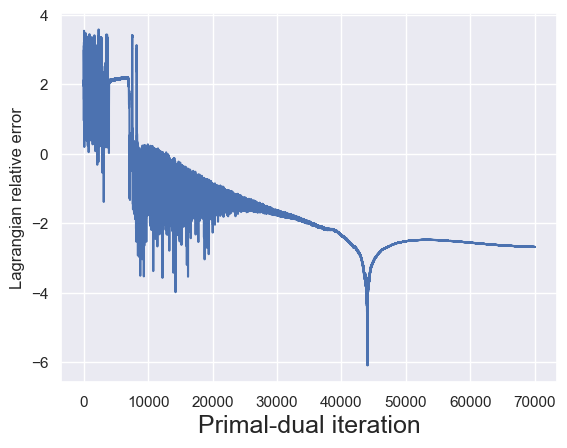

In [13]:
Leval_arr = torch.stack(history['L'])
cost_val = torch.real(torch.tensor(data['cost_mp'][0][0]))
Leval_error = torch.abs(Leval_arr-cost_val)/torch.abs(cost_val)

import seaborn as sns
sns.set_theme()
plt.plot(torch.log10(Leval_error))
plt.xlabel('EG iteration', fontsize=18)
plt.ylabel('Lagrangian relative error')

In [15]:
def shift_phase_to_zero(complex_tensor):
    """
    Shifts phases of all entries relative to the first entry (first entry gets 0 phase)
    """
    # Get magnitudes and phases
    magnitudes = torch.abs(complex_tensor)
    phases = torch.angle(complex_tensor)
    
    # Calculate phase shift 
    phase_shift = phases[0] if phases.shape[0] > 0 else 0.0
    
    # Shift phases
    adjusted_phases = phases - phase_shift
    
    # Convert back to complex 
    adjusted_complex = magnitudes * torch.exp(1j * adjusted_phases)
    
    return adjusted_complex

In [ ]:
with torch.no_grad():
    # Voltage analysis
    v_vqec_full = shift_phase_to_zero(torch.sqrt(mu)*sampling_primal(history['param1'][-1]))
    v_vqec = v_vqec_full[:Nbus]
    
    mse_v = torch.linalg.norm(v_vqec - v_yalmip.to(v_vqec.device))**2 / len(v_yalmip)
    print(f"MSE_v: {mse_v.item():.4e}")
    
    # Compute relative error
    diff = v_vqec-v_yalmip
    relative_error = torch.norm(diff) / torch.norm(v_yalmip)*100
    print(f"Relative Error of v: {relative_error.item():.1f} %")

    # Generation value analysis
    pgen_vqec = []
    qgen_vqec = []
    for k in range(Ngen):
        Mp_k = Mp[:, :, GenInd[k]-1].to(torch.complex128)
        Mq_k = Mq[:, :, GenInd[k]-1].to(torch.complex128)

        v_vqec_col = v_vqec.unsqueeze(1)

        pgen_vqec.append((v_vqec_col.H @ Mp_k @ v_vqec_col)[0][0])
        qgen_vqec.append((v_vqec_col.H @ Mq_k @ v_vqec_col)[0][0])

    genvqec = torch.cat([torch.stack(pgen_vqec), v_vqec[GenInd-1]])
    gen_val = torch.cat([gen_val[:Ngen], v_yalmip[GenInd-1]])
    mse_gen = torch.linalg.norm(gen_val - genvqec.squeeze())**2 / len(gen_val)
    print(f"MSE of gen: {mse_gen.item():.4e}")
    
    error_gen = torch.linalg.norm(gen_val - genvqec.squeeze()) / torch.linalg.norm(gen_val)*100
    print(f"Relative error of gen: {error_gen.item():.2f} %")

In [16]:
# Dual variable analysis
dual_vqec = torch.sqrt(nu) * sampling_dual(history['param2'][-1])
lambda_vqec_full = torch.abs(dual_vqec)**2
lambda_vqec = lambda_vqec_full[:Mc]